# PULSEE $\frac{\pi}{2}$ - Pulse, a Simple Zeeman Interaction
Jiwoo Seo, Ilija Nikolov, Alex Aoki

## Imports

In [2]:
import numpy as np

import pulsee.plot as psplt  # 'psplt' = 'pulsee plot'
from pulsee import operators as op, simulation as sim
from pulsee.pulses import Pulses

## Quantum System Setup
Spin-$\frac{1}{2}$ system with $\gamma/2\pi = 5.00$ MHz/T (see Candoli thesis §4.1) and $B_0 = 1 T:

In [3]:
QUANTUM_NUMBER = 1 / 2  # spin 1/2
GAMMA_2PI = 5  # MHz/T
B0 = 1  # Tesla
W0 = -2 * np.pi * GAMMA_2PI * B0  # units of radial frequency

spin_par = {"quantum number": QUANTUM_NUMBER, "gamma/2pi": GAMMA_2PI}
zeem_par = {"field magnitude": B0, "theta_z": 0, "phi_z": 0}

print("Larmor frequency:", W0 / (2 * np.pi), "MHz")

Larmor frequency: -5.0 MHz


## Experimental Parameters

In [4]:
T2 = 2  # microS. A relatively fast T2 time for easy visualization at the end of the notebook
ACQUISITION_TIME = 100  # microS
N_POINTS_EVOLVE = 1000
N_POINTS_FID = 10000

## Run `sim.nuclear_system_setup` after setting up the arguments
Initial state is canonical by default

### Hamiltonians
Here we would add the desired Hamiltonian interaction terms.
However, this example notebook has a simple spin-1/2 system, so no interactions terms in the Hamiltonian exists and no additional arguments will be passed into `nuclear_system_setup()`.

In [5]:
spin, h_unperturbed, rho_0 = sim.nuclear_system_setup(
    spin_par=spin_par, zeem_par=zeem_par
)

### Print out the initial state density matrix and its absorption spectrum

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.91679844 -0.        ]
 [-0.          0.08320156]]

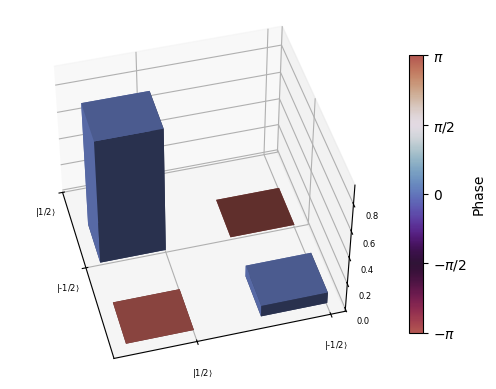

(<Figure size 640x480 with 2 Axes>, <Axes3D: >)

In [6]:
display(rho_0)
psplt.plot_complex_density_matrix(rho_0)

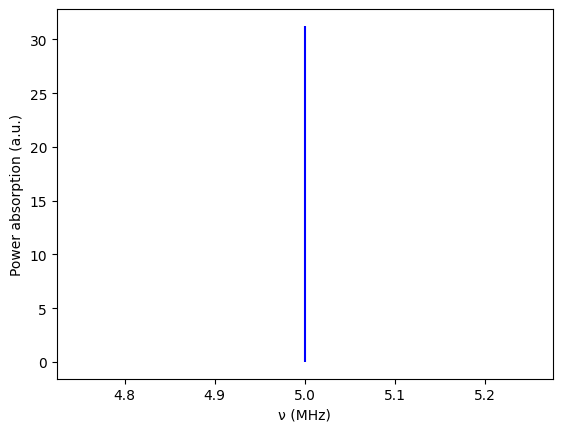

In [7]:
f, p = sim.power_absorption_spectrum(spin, h_unperturbed, normalized=True)
_ = psplt.plot_power_absorption_spectrum(f, p)

## Pulse
Set up single mode pulse of form
$$\mathbf{B}_1(t) = 2 B_1 \cos(2\pi \nu + \delta)\cdot \hat{\mathbf{n}}(\theta, \phi)$$
where $\theta$ and $\phi$ are the polar and azimuthal angles respectively.

For simplest case apply $\pi/2$ pulse with $B_1 = B_0 / 10 $, $ \nu = (\gamma/2\pi) \cdot B_0 $, $\delta = \phi =0$, $\theta=\pi/2$ --> $I_x$ pulse.

In [8]:
B1 = B0 / 100
PHASE_B1 = np.pi * 0
POLAR_B1 = np.pi / 2  # pulse direction is in the transverse plane
AZIMUTHAL_B1 = 0  # x-direction pulse
TIP_ANGLE = np.pi / 2

# Since numerator is in radians, denominator must be in units of radial frequency:
PULSE_TIME = TIP_ANGLE / (2 * np.pi * GAMMA_2PI * B1)

mode = Pulses(
    frequencies=[W0],
    amplitudes=[B1],
    phases=[PHASE_B1],
    theta_p=[POLAR_B1],
    phi_p=[AZIMUTHAL_B1],
    pulse_times=[PULSE_TIME],
)

##  Simulation

### We apply the pulse using two methods
1. The 'mesolve' method using the QuTiP's time evolution functions which uses ODE integration of the time-dependent Hamiltonian
2. The 'magnus' method, using the Magnus expansion, an analytical approximation

### mesolve:

In [9]:
evolved_dm_mesolve = sim.evolve(
    spin, h_unperturbed, rho_0, solver="mesolve", mode=mode, n_points=100
)
evolved_dm_mesolve

  0%|          | 0/99 [00:00<?, ?it/s]

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.50003919-8.35216569e-17j 0.00108562+4.16779686e-01j]
 [0.00108562-4.16779686e-01j 0.49996081+8.35216569e-17j]]

### magnus:

In [10]:
# Evolve the initial state until a square pi/2 pulse is applied using the magnus solver in the interaction picture
evolved_dm = sim.evolve(
    spin,
    h_unperturbed,
    rho_0,
    solver="magnus",
    picture="IP",
    mode=mode,
    n_points=N_POINTS_EVOLVE,
    order=1,
)
evolved_dm

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[5.00000000e-01+0.j         1.33019891e-16+0.41679844j]
 [1.33019891e-16-0.41679844j 5.00000000e-01+0.j        ]]

In [11]:
RRF_par = {"nu_RRF": -W0 / (2 * np.pi), "theta_RRF": 0, "phi_RRF": 0}
RRF_par

{'nu_RRF': 5.0, 'theta_RRF': 0, 'phi_RRF': 0}

In [12]:
# Evolve the initial state until a square pi/2 pulse is applied using the magnus solver
evolved_dm_magnus = sim.evolve(
    spin,
    h_unperturbed,
    rho_0,
    solver="magnus",
    picture="RRF",
    RRF_par=RRF_par,
    mode=mode,
    n_points=30,
    order=1,
)
evolved_dm_magnus

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[5.00000000e-01+0.j         9.77073379e-16+0.41679844j]
 [9.77073379e-16-0.41679844j 5.00000000e-01+0.j        ]]

### Compare to the theoretical output:
The theoretical output is simply a $\pi/2$ rotation along x of the initial state

Both methods clearly agree well with the theoretical output!

In [13]:
op.apply_rot_pulse(rho_0, np.pi / 2, spin.I["x"])

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5+0.j         0. +0.41679844j]
 [0. -0.41679844j 0.5+0.j        ]]

### Visualize the input and output:

Initial state


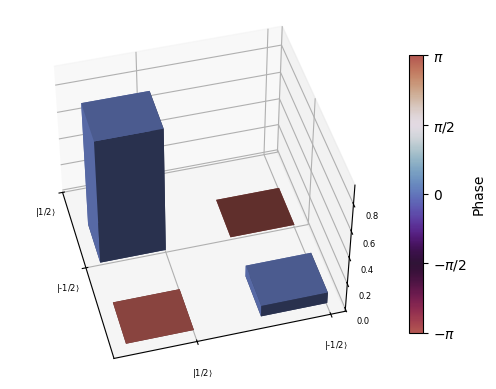

Evolved


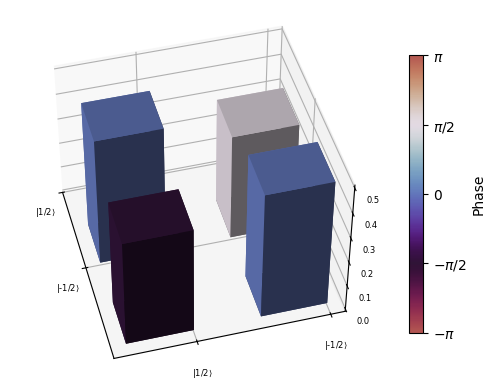

In [14]:
print("Initial state")
_ = psplt.plot_complex_density_matrix(rho_0)
print("Evolved")
_ = psplt.plot_complex_density_matrix(evolved_dm)

# Generate FID

In [15]:
t, fid = sim.FID_signal(
    spin,
    h_unperturbed,
    evolved_dm,
    acquisition_time=ACQUISITION_TIME,
    T2=T2,
    n_points=N_POINTS_FID,
)

In [16]:
f, ft = sim.fourier_transform_signal(fid, t, padding=2)

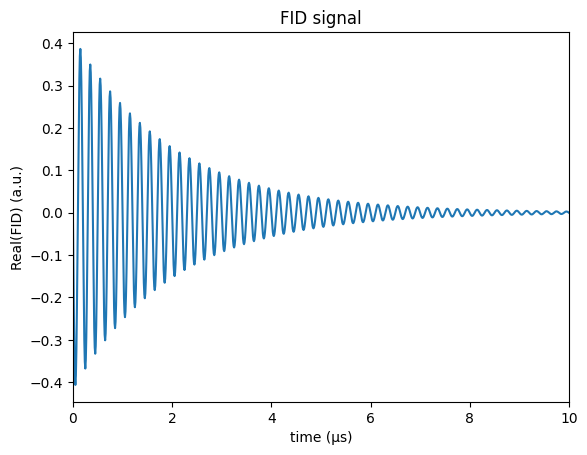

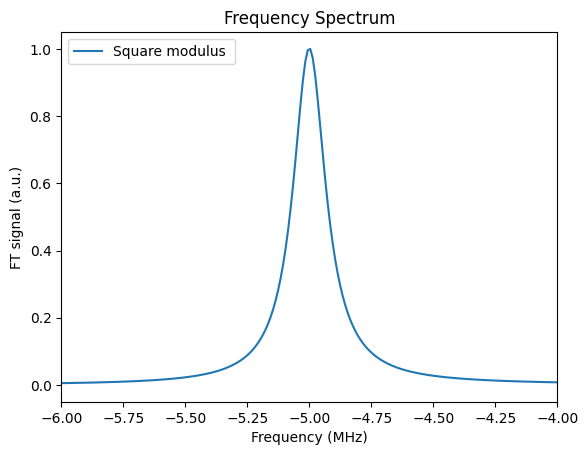

In [17]:
psplt.plot_real_part_FID_signal(t, fid, xlim=(0, 10))
_ = psplt.plot_fourier_transform(f, ft, square_modulus=True, save=False, xlim=(-6, -4))